# Million Song Dataset (MSD) - Unsupervised Music Clustering Analysis

**Comprehensive clustering analysis without genre labels**

This notebook performs:
- **Unsupervised clustering** using multiple algorithms (KMeans, MiniBatchKMeans, Spectral, GMM, DBSCAN)
- **Internal validation metrics** (Silhouette, Davies-Bouldin, Calinski-Harabasz)
- **Multiple train/test splits** with different seeds
- **Automatic DBSCAN parameter tuning** using k-distance graphs
- **Comprehensive W&B logging** with visualizations
- **Kaggle-style reporting** and analysis

## 📦 Install Dependencies

In [1]:
!pip install -q wandb scikit-learn pandas numpy matplotlib seaborn tqdm

## 📚 Import Libraries

In [ ]:
import os, warnings, math, itertools
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)

import wandb
wandb.login(key="")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anis42390 (anis42390-national-institute-of-technology-hamirpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 📂 Load MSD Dataset

Loading the Million Song Dataset features. Since this dataset doesn't have genre labels, we'll perform **purely unsupervised** clustering.

In [3]:
# Set your path here - adjust based on your environment
DATA_PATH = "/kaggle/input/msdhd5/msd.csv"

df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"\nDataset info:")
print(f"  Total samples: {len(df):,}")
print(f"  Total features: {len(df.columns)}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️  Missing values detected:")
    print(missing[missing > 0])
else:
    print("\n✅ No missing values")

df.head()

Dataset shape: (10000, 64)
Columns: ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var']...

Dataset info:
  Total samples: 10,000
  Total features: 64
  Memory usage: 6.08 MB

✅ No missing values


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,key,mode,time_signature,loudness,label
0,TRBCTBL128F931FF29.h5,600.37179,0.430184,0.067461,-8.926969,18.206259,45.691874,18.122857,46.781657,3228.676910,...,1069.530876,5.822904,710.201775,-6.897677,580.231160,4,0,3,-7.512,unknown
1,TRBCTFW128F931FBE9.h5,157.02159,0.445722,0.064710,-6.491233,8.748406,50.893890,9.297896,26.180626,1468.387763,...,425.709150,1.057707,410.123882,3.528948,357.117812,2,0,4,-4.813,unknown
2,TRBCTKV128F42222BD.h5,462.07955,0.363215,0.088287,-10.612609,39.925235,42.305276,41.066491,-2.942522,2584.361866,...,1679.244522,5.392033,888.957672,3.433863,794.876912,4,0,4,-6.947,unknown
3,TRBCTEE128F42438DC.h5,267.25832,0.272869,0.089189,-9.826327,20.310880,46.097064,20.651246,24.474001,3009.284336,...,833.965003,-5.630011,703.918171,-9.650004,604.368576,9,0,4,-7.367,unknown
4,TRBCTBG128F42B7E1B.h5,266.03057,0.367237,0.072203,-9.495149,26.264436,47.732507,26.780136,2.084684,2546.803092,...,323.850989,-4.490864,334.878319,-4.470220,328.786986,7,1,4,-6.404,unknown


## 🧹 Data Preprocessing

Remove non-numeric columns (filename, length, label if present) and prepare features for clustering.

In [4]:
# Drop non-numeric columns
drop_cols = [c for c in ["filename", "length", "label"] if c in df.columns]
print(f"Dropping columns: {drop_cols}")

X = df.drop(columns=drop_cols).values.astype(float)

# Check if label column exists for reference (but won't use it for clustering)
has_labels = "label" in df.columns
if has_labels:
    y_text = df["label"].values
    print(f"\nNote: Labels found in dataset: {np.unique(y_text)}")
    print("However, we'll perform UNSUPERVISED clustering (ignoring labels)")
else:
    print("\n✓ No labels in dataset - pure unsupervised learning")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nScaled features shape: {X_scaled.shape}")
print(f"Feature statistics after scaling:")
print(f"  Mean: {X_scaled.mean():.6f} (should be ~0)")
print(f"  Std: {X_scaled.std():.6f} (should be ~1)")
print(f"  Min: {X_scaled.min():.2f}")
print(f"  Max: {X_scaled.max():.2f}")

Dropping columns: ['filename', 'length', 'label']

Note: Labels found in dataset: ['unknown']
However, we'll perform UNSUPERVISED clustering (ignoring labels)

Scaled features shape: (10000, 61)
Feature statistics after scaling:
  Mean: 0.000000 (should be ~0)
  Std: 1.000000 (should be ~1)
  Min: -9.66
  Max: 22.71


## 🎯 Determine Optimal Number of Clusters

Since we don't have labels, we'll use the **Elbow Method** and **Silhouette Analysis** to find the optimal number of clusters.

Using sample of 5,000 points for cluster optimization

Testing different numbers of clusters...


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


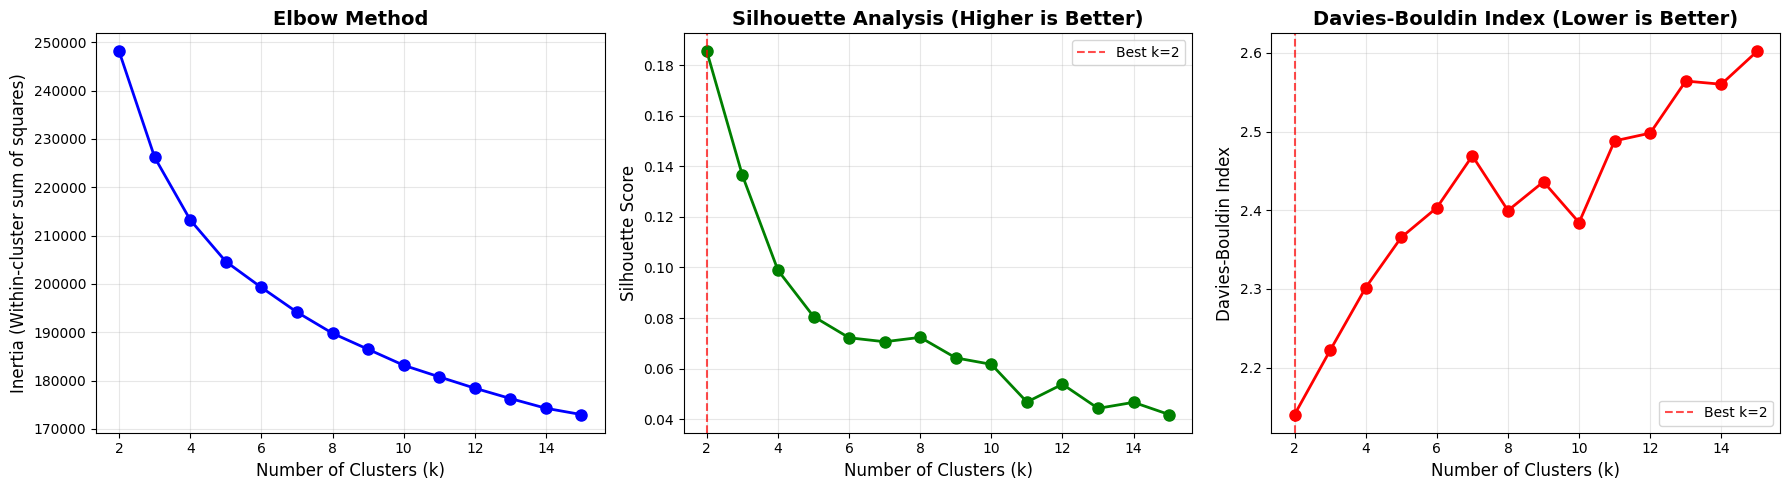


📊 Cluster Optimization Results:
  Best k by Silhouette Score: 2 (score: 0.1854)
  Best k by Davies-Bouldin: 2 (score: 2.1402)

🎯 Selected optimal k = 2 for experiments


In [5]:
# Test different numbers of clusters
# For large datasets, we'll use a sample for speed
sample_size = min(5000, len(X_scaled))
print(f"Using sample of {sample_size:,} points for cluster optimization")

sample_indices = np.random.RandomState(42).choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

k_range = range(2, 16)  # Test 2 to 15 clusters
inertias = []
silhouettes = []
davies_bouldins = []

print("\nTesting different numbers of clusters...")
for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_sample, labels))
    davies_bouldins.append(davies_bouldin_score(X_sample, labels))

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette score
axes[1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
best_sil_k = k_range[np.argmax(silhouettes)]
axes[1].axvline(best_sil_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_sil_k}')
axes[1].legend()

# Davies-Bouldin index
axes[2].plot(k_range, davies_bouldins, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
best_db_k = k_range[np.argmin(davies_bouldins)]
axes[2].axvline(best_db_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_db_k}')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Cluster Optimization Results:")
print(f"  Best k by Silhouette Score: {best_sil_k} (score: {max(silhouettes):.4f})")
print(f"  Best k by Davies-Bouldin: {best_db_k} (score: {min(davies_bouldins):.4f})")

# Choose optimal k (prioritize silhouette score)
optimal_k = best_sil_k
print(f"\n🎯 Selected optimal k = {optimal_k} for experiments")

## 🔍 Auto-tune DBSCAN Parameters

Using k-distance graph (elbow method) to find optimal `eps` parameter for DBSCAN.

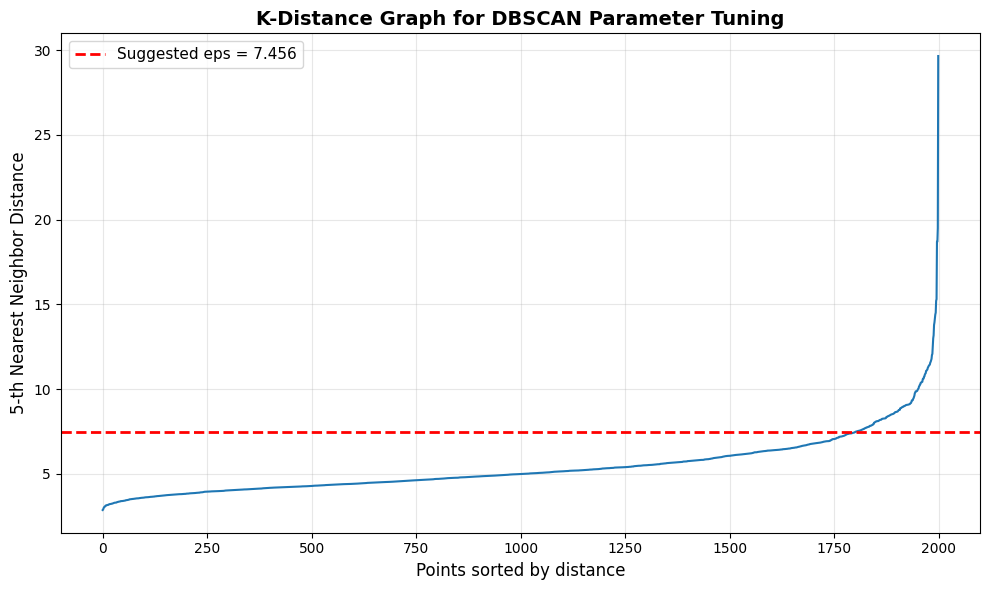


🎯 Auto-tuned DBSCAN parameters:
  eps = 7.456
  min_samples = 5

Testing DBSCAN with optimal parameters...
  Clusters found: 1
  Noise points: 129/2000 (6.5%)
  ⚠️  Need at least 2 clusters for valid metrics


In [6]:
def find_optimal_dbscan_eps(X, min_samples=3, k=None):
    """
    Find optimal DBSCAN eps using k-distance graph (elbow method).
    
    Parameters:
    -----------
    X : array-like
        Training data (scaled)
    min_samples : int
        DBSCAN min_samples parameter
    k : int, optional
        k for k-nearest neighbors (default: min_samples)
    
    Returns:
    --------
    float : Suggested eps value
    """
    from sklearn.neighbors import NearestNeighbors
    
    if k is None:
        k = min_samples
    
    # Fit nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Get k-th nearest neighbor distances
    k_distances = np.sort(distances[:, k-1])
    
    # Use 90th percentile as heuristic
    suggested_eps = np.percentile(k_distances, 90)
    
    return suggested_eps, k_distances

# Find optimal eps on a sample
sample_size_dbscan = min(2000, len(X_scaled))
sample_indices_dbscan = np.random.RandomState(42).choice(len(X_scaled), sample_size_dbscan, replace=False)
X_sample_dbscan = X_scaled[sample_indices_dbscan]

min_samples = 5
optimal_eps, k_distances = find_optimal_dbscan_eps(X_sample_dbscan, min_samples=min_samples)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances, linewidth=1.5)
plt.axhline(y=optimal_eps, color='r', linestyle='--', linewidth=2, label=f'Suggested eps = {optimal_eps:.3f}')
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph for DBSCAN Parameter Tuning', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Auto-tuned DBSCAN parameters:")
print(f"  eps = {optimal_eps:.3f}")
print(f"  min_samples = {min_samples}")

# Test DBSCAN with optimal parameters
print(f"\nTesting DBSCAN with optimal parameters...")
dbscan_test = DBSCAN(eps=optimal_eps, min_samples=min_samples)
labels_test = dbscan_test.fit_predict(X_sample_dbscan)

n_clusters_found = len(set(labels_test)) - (1 if -1 in labels_test else 0)
n_noise = list(labels_test).count(-1)

print(f"  Clusters found: {n_clusters_found}")
print(f"  Noise points: {n_noise}/{len(labels_test)} ({100*n_noise/len(labels_test):.1f}%)")

if n_clusters_found >= 2:
    valid_mask = labels_test >= 0
    if np.sum(valid_mask) > 0:
        try:
            sil = silhouette_score(X_sample_dbscan[valid_mask], labels_test[valid_mask])
            print(f"  ✅ Silhouette Score: {sil:.4f}")
        except:
            print(f"  ⚠️  Could not compute silhouette")
else:
    print(f"  ⚠️  Need at least 2 clusters for valid metrics")

## 🛠️ Helper Functions

Functions for metrics computation, visualization, and cluster assignment.

In [7]:
def safe_internal_metrics(X, labels):
    """
    Calculate internal clustering metrics with proper validation.
    Returns NaN if conditions aren't met for valid computation.
    """
    metrics = {}
    
    # Get unique non-noise labels (exclude -1 from DBSCAN)
    unique_labels = np.unique(labels)
    valid_labels = unique_labels[unique_labels >= 0]
    
    # Need at least 2 clusters
    if len(valid_labels) < 2:
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        return metrics
    
    # For DBSCAN: filter out noise points (-1 labels)
    if -1 in unique_labels:
        mask = labels >= 0
        X_filtered = X[mask]
        labels_filtered = labels[mask]
        
        if len(X_filtered) < 2:
            metrics["silhouette"] = np.nan
            metrics["davies_bouldin"] = np.nan
            metrics["calinski_harabasz"] = np.nan
            return metrics
    else:
        X_filtered = X
        labels_filtered = labels
    
    # Check that each cluster has at least 2 samples
    unique_filtered = np.unique(labels_filtered)
    valid = all(np.sum(labels_filtered == label) >= 2 for label in unique_filtered)
    
    if not valid or len(unique_filtered) < 2:
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
        return metrics
    
    # Compute metrics
    try:
        metrics["silhouette"] = float(silhouette_score(X_filtered, labels_filtered))
        metrics["davies_bouldin"] = float(davies_bouldin_score(X_filtered, labels_filtered))
        metrics["calinski_harabasz"] = float(calinski_harabasz_score(X_filtered, labels_filtered))
    except Exception as e:
        print(f"Warning: Error computing metrics: {e}")
        metrics["silhouette"] = np.nan
        metrics["davies_bouldin"] = np.nan
        metrics["calinski_harabasz"] = np.nan
    
    return metrics

def pca_scatter(X, labels, title="PCA (2D)"):
    """Create PCA 2D scatter plot."""
    p = PCA(n_components=2, random_state=42)
    emb = p.fit_transform(X)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Handle DBSCAN noise points
    unique_labels = np.unique(labels)
    if -1 in unique_labels:
        # Plot noise points separately
        noise_mask = labels == -1
        valid_mask = labels >= 0
        
        if np.sum(valid_mask) > 0:
            sc = ax.scatter(emb[valid_mask, 0], emb[valid_mask, 1], 
                          c=labels[valid_mask], cmap='tab20', alpha=0.6, s=30)
        if np.sum(noise_mask) > 0:
            ax.scatter(emb[noise_mask, 0], emb[noise_mask, 1], 
                      c='gray', alpha=0.3, s=10, label='Noise')
            ax.legend()
    else:
        sc = ax.scatter(emb[:, 0], emb[:, 1], c=labels, cmap='tab20', alpha=0.6, s=30)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("PC1", fontsize=12)
    ax.set_ylabel("PC2", fontsize=12)
    ax.grid(True, alpha=0.3)
    
    if -1 not in unique_labels or np.sum(labels >= 0) > 0:
        plt.colorbar(sc, ax=ax, label='Cluster')
    
    return fig

def assign_by_nearest_centroid(X_train, train_labels, X_test):
    """Assign test samples to nearest centroid of clusters found in train."""
    valid_labels = [c for c in np.unique(train_labels) if c >= 0]
    
    if len(valid_labels) == 0:
        return np.zeros(len(X_test), dtype=int)
    
    centroids = []
    for c in valid_labels:
        mask = train_labels == c
        if np.sum(mask) > 0:
            centroids.append(X_train[mask].mean(axis=0))
    
    if len(centroids) == 0:
        return np.zeros(len(X_test), dtype=int)
    
    centroids = np.vstack(centroids)
    dists = ((X_test[:, None, :] - centroids[None, :, :])**2).sum(axis=2)
    assigned_indices = dists.argmin(axis=1)
    
    return np.array([valid_labels[i] for i in assigned_indices])

print("✅ Helper functions defined")

✅ Helper functions defined


## 🧪 Core Experiment Runner

Train/test clustering with comprehensive metrics and W&B logging.

In [8]:
def run_clustering_experiment(
        algo_name, algo, X_train, X_test, run_cfg, log_to_wandb=True):
    """
    Fits on train, predicts on train + test.
    For algos without .predict (e.g., Spectral, DBSCAN), assign test by nearest centroid.
    Logs internal metrics: Silhouette, Davies-Bouldin, Calinski-Harabasz.
    """

    # Fit
    if hasattr(algo, "fit_predict"):
        train_labels = algo.fit_predict(X_train)
    else:
        algo.fit(X_train)
        train_labels = getattr(algo, "labels_", None)
        if train_labels is None and hasattr(algo, "predict"):
            train_labels = algo.predict(X_train)
        if train_labels is None:
            train_labels = algo.fit(X_train).predict(X_train)

    # Predict for test
    if hasattr(algo, "predict"):
        try:
            test_labels = algo.predict(X_test)
        except Exception:
            test_labels = assign_by_nearest_centroid(X_train, train_labels, X_test)
    else:
        test_labels = assign_by_nearest_centroid(X_train, train_labels, X_test)

    # Internal metrics on test
    metrics = safe_internal_metrics(X_test, test_labels)
    
    # Add cluster statistics
    unique_test = np.unique(test_labels)
    n_clusters_found = len([c for c in unique_test if c >= 0])
    n_noise = np.sum(test_labels == -1)
    
    metrics["n_clusters"] = n_clusters_found
    metrics["n_noise_points"] = int(n_noise)
    metrics["noise_percentage"] = float(n_noise / len(test_labels) * 100)
    
    # Cluster size distribution
    for label in unique_test:
        if label >= 0:
            count = np.sum(test_labels == label)
            metrics[f"cluster_{label}_size"] = int(count)

    # Visualization
    fig_pred = pca_scatter(X_test, test_labels, f"PCA Test — {algo_name}")

    if log_to_wandb:
        wandb.log(metrics)
        wandb.log({"pca_clusters": wandb.Image(fig_pred)})

    plt.close(fig_pred)
    return metrics, train_labels, test_labels

print("✅ Experiment runner defined")

✅ Experiment runner defined


## 🎯 Algorithm Configuration

Define all clustering algorithms with optimal parameters.

In [9]:
def make_algorithms(n_clusters, dbscan_eps=optimal_eps, dbscan_min_samples=min_samples):
    """Create dictionary of clustering algorithms."""
    return {
        "KMeans": KMeans(
            n_clusters=n_clusters, 
            random_state=42, 
            n_init="auto",
            max_iter=300
        ),
        "MiniBatchKMeans": MiniBatchKMeans(
            n_clusters=n_clusters, 
            random_state=42, 
            batch_size=256, 
            n_init="auto",
            max_iter=300
        ),
        "Spectral": SpectralClustering(
            n_clusters=n_clusters, 
            affinity="nearest_neighbors", 
            n_neighbors=10, 
            random_state=42, 
            assign_labels="kmeans"
        ),
        "GMM": GaussianMixture(
            n_components=n_clusters, 
            covariance_type="full", 
            random_state=42,
            max_iter=200
        ),
        "DBSCAN": DBSCAN(
            eps=dbscan_eps, 
            min_samples=dbscan_min_samples
        )
    }

print(f"✅ Algorithms configured with {optimal_k} clusters")

✅ Algorithms configured with 2 clusters


## 🚀 Run Complete Experiment Grid

**Grid of experiments:** Multiple train/test splits × Multiple random seeds × All algorithms

This will:
1. Test different train/test ratios
2. Use multiple random seeds for robustness
3. Run all 5 clustering algorithms
4. Log everything to W&B with visualizations

In [10]:
# Experiment configuration
PROJECT = "msd-clustering"
ENTITY = None  # Set to your W&B username if needed

SPLITS = [0.5, 0.6, 0.7, 0.8]  # train ratios
SEEDS = [0, 42, 1337]           # random seeds for robustness

ALL_RUNS = []

print(f"🚀 Starting experiment grid:")
print(f"  Dataset: MSD ({len(X_scaled):,} samples, {X_scaled.shape[1]} features)")
print(f"  Train/test splits: {SPLITS}")
print(f"  Random seeds: {SEEDS}")
print(f"  Algorithms: KMeans, MiniBatchKMeans, Spectral, GMM, DBSCAN")
print(f"  Target clusters: {optimal_k}")
print(f"  Total runs: {len(SPLITS) * len(SEEDS) * 5} experiments\n")

total_experiments = len(SPLITS) * len(SEEDS) * 5
current_experiment = 0

for train_ratio in SPLITS:
    test_size = 1.0 - train_ratio
    
    for seed in SEEDS:
        print(f"\n{'='*80}")
        print(f"Train Ratio: {train_ratio:.1%} | Test Size: {test_size:.1%} | Seed: {seed}")
        print(f"{'='*80}")
        
        # Split data
        X_tr, X_te = train_test_split(
            X_scaled, test_size=test_size, random_state=seed
        )
        
        print(f"Train: {len(X_tr):,} samples | Test: {len(X_te):,} samples\n")
        
        algos = make_algorithms(optimal_k)

        for algo_name, algo in algos.items():
            current_experiment += 1
            print(f"[{current_experiment}/{total_experiments}] Running {algo_name}...")
            
            cfg = {
                "algo": algo_name,
                "train_ratio": train_ratio,
                "test_size": test_size,
                "random_state": seed,
                "n_clusters_target": optimal_k,
                "dataset": "MSD",
                "total_samples": len(X_scaled),
                "n_features": X_scaled.shape[1],
                "train_samples": len(X_tr),
                "test_samples": len(X_te)
            }
            
            if algo_name == "DBSCAN":
                cfg["dbscan_eps"] = optimal_eps
                cfg["dbscan_min_samples"] = min_samples

            run = wandb.init(
                project=PROJECT, 
                entity=ENTITY, 
                config=cfg,
                name=f"{algo_name}-tr{int(train_ratio*100)}-seed{seed}",
                reinit=True
            )
            
            try:
                res, tr_lab, te_lab = run_clustering_experiment(
                    algo_name, algo, X_tr, X_te, cfg, log_to_wandb=True
                )
                
                # Print summary
                print(f"  ✓ Clusters: {res.get('n_clusters', 'N/A')}")
                if not np.isnan(res.get('silhouette', np.nan)):
                    print(f"  ✓ Silhouette: {res['silhouette']:.4f}")
                else:
                    print(f"  ⚠ Silhouette: N/A (insufficient clusters)")
                
                if res.get('n_noise_points', 0) > 0:
                    print(f"  ℹ Noise: {res['noise_percentage']:.1f}%")
                
                ALL_RUNS.append((cfg, res))
                
            except Exception as e:
                print(f"  ✗ Error: {str(e)}")
            
            finally:
                wandb.finish()

print(f"\n{'='*80}")
print(f"✅ All experiments completed! Total runs: {len(ALL_RUNS)}")
print(f"{'='*80}")

🚀 Starting experiment grid:
  Dataset: MSD (10,000 samples, 61 features)
  Train/test splits: [0.5, 0.6, 0.7, 0.8]
  Random seeds: [0, 42, 1337]
  Algorithms: KMeans, MiniBatchKMeans, Spectral, GMM, DBSCAN
  Target clusters: 2
  Total runs: 60 experiments


Train Ratio: 50.0% | Test Size: 50.0% | Seed: 0
Train: 5,000 samples | Test: 5,000 samples

[1/60] Running KMeans...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


  ✓ Clusters: 2
  ✓ Silhouette: 0.1868


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,1003.58835
cluster_0_size,3092
cluster_1_size,1908


[2/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1667


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,986.68
cluster_0_size,2781
cluster_1_size,2219


[3/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1152


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,875.62742
cluster_0_size,3111
cluster_1_size,1889


[4/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2130


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,625.94684
cluster_0_size,3630
cluster_1_size,1370


[5/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,5000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 50.0% | Test Size: 50.0% | Seed: 42
Train: 5,000 samples | Test: 5,000 samples

[6/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1814


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,973.50846
cluster_0_size,1911
cluster_1_size,3089


[7/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2239


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,928.57374
cluster_0_size,1270
cluster_1_size,3730


[8/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1127


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,863.02099
cluster_0_size,3190
cluster_1_size,1810


[9/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2030


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,595.60491
cluster_0_size,1409
cluster_1_size,3591


[10/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,5000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 50.0% | Test Size: 50.0% | Seed: 1337
Train: 5,000 samples | Test: 5,000 samples

[11/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1834


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,955.27222
cluster_0_size,1858
cluster_1_size,3142


[12/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2321


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,882.83173
cluster_0_size,3857
cluster_1_size,1143


[13/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1146


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,858.32662
cluster_0_size,3153
cluster_1_size,1847


[14/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1861


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,605.44816
cluster_0_size,1578
cluster_1_size,3422


[15/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,5000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 60.0% | Test Size: 40.0% | Seed: 0
Train: 6,000 samples | Test: 4,000 samples

[16/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1893


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,802.90249
cluster_0_size,2495
cluster_1_size,1505


[17/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2040


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,797.98343
cluster_0_size,2695
cluster_1_size,1305


[18/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1148


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,699.30182
cluster_0_size,1518
cluster_1_size,2482


[19/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2095


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,511.44951
cluster_0_size,2861
cluster_1_size,1139


[20/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,4000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 60.0% | Test Size: 40.0% | Seed: 42
Train: 6,000 samples | Test: 4,000 samples

[21/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1837


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,765.99313
cluster_0_size,1480
cluster_1_size,2520


[22/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1874


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,755.86498
cluster_0_size,2609
cluster_1_size,1391


[23/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1140


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,690.07536
cluster_0_size,2515
cluster_1_size,1485


[24/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2015


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,474.59848
cluster_0_size,1142
cluster_1_size,2858


[25/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,4000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 60.0% | Test Size: 40.0% | Seed: 1337
Train: 6,000 samples | Test: 4,000 samples

[26/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1835


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,765.97367
cluster_0_size,2518
cluster_1_size,1482


[27/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1549


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,745.54109
cluster_0_size,1857
cluster_1_size,2143


[28/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1144


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,691.2547
cluster_0_size,1462
cluster_1_size,2538


[29/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1974


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,474.93355
cluster_0_size,2838
cluster_1_size,1162


[30/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,4000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 70.0% | Test Size: 30.0% | Seed: 0
Train: 6,999 samples | Test: 3,001 samples

[31/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1903


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,599.75427
cluster_0_size,1126
cluster_1_size,1875


[32/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2436


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,567.41653
cluster_0_size,696
cluster_1_size,2305


[33/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1147


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,522.37453
cluster_0_size,1846
cluster_1_size,1155


[34/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2072


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,386.91234
cluster_0_size,874
cluster_1_size,2127


[35/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,3001
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 70.0% | Test Size: 30.0% | Seed: 42
Train: 6,999 samples | Test: 3,001 samples

[36/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1853


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,584.57982
cluster_0_size,1886
cluster_1_size,1115


[37/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1836


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,584.68704
cluster_0_size,1870
cluster_1_size,1131


[38/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1142


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,520.26365
cluster_0_size,1102
cluster_1_size,1899


[39/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.2023


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,365.68914
cluster_0_size,2139
cluster_1_size,862


[40/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,3001
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 70.0% | Test Size: 30.0% | Seed: 1337
Train: 6,999 samples | Test: 3,001 samples

[41/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1809


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,576.00764
cluster_0_size,1871
cluster_1_size,1130


[42/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1446


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,566.33856
cluster_0_size,1470
cluster_1_size,1531


[43/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1131


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,515.56657
cluster_0_size,1091
cluster_1_size,1910


[44/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1947


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,347.55173
cluster_0_size,2128
cluster_1_size,873


[45/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,3001
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 80.0% | Test Size: 20.0% | Seed: 0
Train: 8,000 samples | Test: 2,000 samples

[46/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1856


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,385.28213
cluster_0_size,757
cluster_1_size,1243


[47/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1638


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,354.71797
cluster_0_size,854
cluster_1_size,1146


[48/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1104


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,333.16338
cluster_0_size,1242
cluster_1_size,758


[49/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1959


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,238.64372
cluster_0_size,604
cluster_1_size,1396


[50/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,2000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 80.0% | Test Size: 20.0% | Seed: 42
Train: 8,000 samples | Test: 2,000 samples

[51/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1888


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,400.57955
cluster_0_size,1258
cluster_1_size,742


[52/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1830


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,400.48564
cluster_0_size,779
cluster_1_size,1221


[53/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1162


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,354.26997
cluster_0_size,1262
cluster_1_size,738


[54/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1998


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,254.13723
cluster_0_size,1404
cluster_1_size,596


[55/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,2000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



Train Ratio: 80.0% | Test Size: 20.0% | Seed: 1337
Train: 8,000 samples | Test: 2,000 samples

[56/60] Running KMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1795


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,383.96197
cluster_0_size,750
cluster_1_size,1250


[57/60] Running MiniBatchKMeans...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1906


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,378.60539
cluster_0_size,1327
cluster_1_size,673


[58/60] Running Spectral...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1176


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,353.90222
cluster_0_size,1257
cluster_1_size,743


[59/60] Running GMM...


  ✓ Clusters: 2
  ✓ Silhouette: 0.1918


calinski_harabasz,▁
cluster_0_size,▁
cluster_1_size,▁
davies_bouldin,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
silhouette,▁
calinski_harabasz,226.20367
cluster_0_size,570
cluster_1_size,1430


[60/60] Running DBSCAN...


  ✓ Clusters: 1
  ⚠ Silhouette: N/A (insufficient clusters)


cluster_0_size,▁
n_clusters,▁
n_noise_points,▁
noise_percentage,▁
calinski_harabasz,nan
cluster_0_size,2000
davies_bouldin,nan
n_clusters,1
n_noise_points,0
noise_percentage,0
silhouette,nan



✅ All experiments completed! Total runs: 60


## 📊 Aggregate Results Analysis

Compile and analyze results from all experiments.

In [11]:
# Create results dataframe
rows = []
for cfg, res in ALL_RUNS:
    row = {**cfg, **res}
    rows.append(row)

res_df = pd.DataFrame(rows)

print("📋 Results Summary:")
print(f"Total experiments: {len(res_df)}")
print(f"\nColumns: {res_df.columns.tolist()}")
print(f"\nFirst few results:")
display(res_df.head(10))

# Statistical summary
numeric_cols = ["silhouette", "davies_bouldin", "calinski_harabasz", "n_clusters", "noise_percentage"]
numeric_cols = [c for c in numeric_cols if c in res_df.columns]

summary = res_df.groupby(["algo", "train_ratio"])[numeric_cols].agg(["mean", "std", "min", "max"])

print(f"\n📈 Statistical Summary (grouped by algorithm and train ratio):")
display(summary)

📋 Results Summary:
Total experiments: 60

Columns: ['algo', 'train_ratio', 'test_size', 'random_state', 'n_clusters_target', 'dataset', 'total_samples', 'n_features', 'train_samples', 'test_samples', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'n_clusters', 'n_noise_points', 'noise_percentage', 'cluster_0_size', 'cluster_1_size', 'dbscan_eps', 'dbscan_min_samples']

First few results:


,algo,train_ratio,test_size,random_state,n_clusters_target,dataset,total_samples,n_features,train_samples,test_samples,silhouette,davies_bouldin,calinski_harabasz,n_clusters,n_noise_points,noise_percentage,cluster_0_size,cluster_1_size,dbscan_eps,dbscan_min_samples
0,KMeans,0.5,0.5,0,2,MSD,10000,61,5000,5000,0.186773,2.105839,1003.588353,2,0,0.0,3092,1908.0,NaN,NaN
1,MiniBatchKMeans,0.5,0.5,0,2,MSD,10000,61,5000,5000,0.166679,2.122337,986.679997,2,0,0.0,2781,2219.0,NaN,NaN
2,Spectral,0.5,0.5,0,2,MSD,10000,61,5000,5000,0.115232,2.053990,875.627419,2,0,0.0,3111,1889.0,NaN,NaN
3,GMM,0.5,0.5,0,2,MSD,10000,61,5000,5000,0.213012,2.636541,625.946845,2,0,0.0,3630,1370.0,NaN,NaN
4,DBSCAN,0.5,0.5,0,2,MSD,10000,61,5000,5000,NaN,NaN,NaN,1,0,0.0,5000,NaN,7.456032,5.0
5,KMeans,0.5,0.5,42,2,MSD,10000,61,5000,5000,0.181384,2.142857,973.508458,2,0,0.0,1911,3089.0,NaN,NaN
6,MiniBatchKMeans,0.5,0.5,42,2,MSD,10000,61,5000,5000,0.223913,2.052575,928.573744,2,0,0.0,1270,3730.0,NaN,NaN
7,Spectral,0.5,0.5,42,2,MSD,10000,61,5000,5000,0.112708,2.049502,863.020994,2,0,0.0,3190,1810.0,NaN,NaN
8,GMM,0.5,0.5,42,2,MSD,10000,61,5000,5000,0.202971,2.717056,595.604910,2,0,0.0,1409,3591.0,NaN,NaN
9,DBSCAN,0.5,0.5,42,2,MSD,10000,61,5000,5000,NaN,NaN,NaN,1,0,0.0,5000,NaN,7.456032,5.0



📈 Statistical Summary (grouped by algorithm and train ratio):


silhouette                                \
                                  mean       std       min       max   
algo            train_ratio                                            
DBSCAN          0.5                NaN       NaN       NaN       NaN   
                0.6                NaN       NaN       NaN       NaN   
                0.7                NaN       NaN       NaN       NaN   
                0.8                NaN       NaN       NaN       NaN   
GMM             0.5           0.200710  0.013574  0.186147  0.213012   
                0.6           0.202806  0.006168  0.197365  0.209506   
                0.7           0.201428  0.006291  0.194731  0.207213   
                0.8           0.195835  0.004009  0.191795  0.199813   
KMeans          0.5           0.183850  0.002724  0.181384  0.186773   
                0.6           0.185485  0.003292  0.183519  0.189286   
                0.7           0.185534  0.004698  0.180940  0.190330   
                0.8           0.184632  0.004690  0.179547  0.188789   
MiniBatchKMeans 0.5           0.207561  0.035640  0.166679  0.232090   
                0.6           0.182087  0.024959  0.154906  0.203976   
                0.7           0.190623  0.049862  0.144641  0.243621   
                0.8           0.179142  0.013781  0.163839  0.190570   
Spectral        0.5           0.114169  0.001308  0.112708  0.115232   
                0.6           0.114405  0.000402  0.114012  0.114817   
                0.7           0.113999  0.000807  0.113109  0.114683   
                0.8           0.114739  0.003813  0.110408  0.117589   

                            davies_bouldin                                \
                                      mean       std       min       max   
algo            train_ratio                                                
DBSCAN          0.5                    NaN       NaN       NaN       NaN   
                0.6                    NaN       NaN       NaN       NaN   
                0.7                    NaN       NaN       NaN       NaN   
                0.8                    NaN       NaN       NaN       NaN   
GMM             0.5               2.689425  0.045814  2.636541  2.717056   
                0.6               2.690409  0.058645  2.622730  2.726223   
                0.7               2.689722  0.070762  2.620276  2.761730   
                0.8               2.721029  0.069679  2.646654  2.784794   
KMeans          0.5               2.131691  0.022458  2.105839  2.146378   
                0.6               2.135093  0.027487  2.103447  2.153013   
                0.7               2.131458  0.021410  2.109849  2.152662   
                0.8               2.135599  0.026803  2.105233  2.155965   
MiniBatchKMeans 0.5               2.070992  0.045055  2.038063  2.122337   
                0.6               2.133221  0.052504  2.074539  2.175754   
                0.7               2.088720  0.081950  1.994127  2.138229   
                0.8               2.166424  0.067352  2.111613  2.241612   
Spectral        0.5               2.054825  0.005787  2.049502  2.060984   
                0.6               2.057381  0.007640  2.051396  2.065987   
                0.7               2.059520  0.009599  2.049314  2.068368   
                0.8               2.064223  0.037911  2.031196  2.105619   

                            calinski_harabasz                         \
                                         mean        std         min   
algo            train_ratio                                            
DBSCAN          0.5                       NaN        NaN         NaN   
                0.6                       NaN        NaN         NaN   
                0.7                       NaN        NaN         NaN   
                0.8                       NaN        NaN         NaN   
GMM             0.5                608.999972  15.479656  595.604910   
                0.6                486.993844 

## 📉 Visualize Results: Algorithm Comparison

Compare all algorithms across different metrics and train ratios.

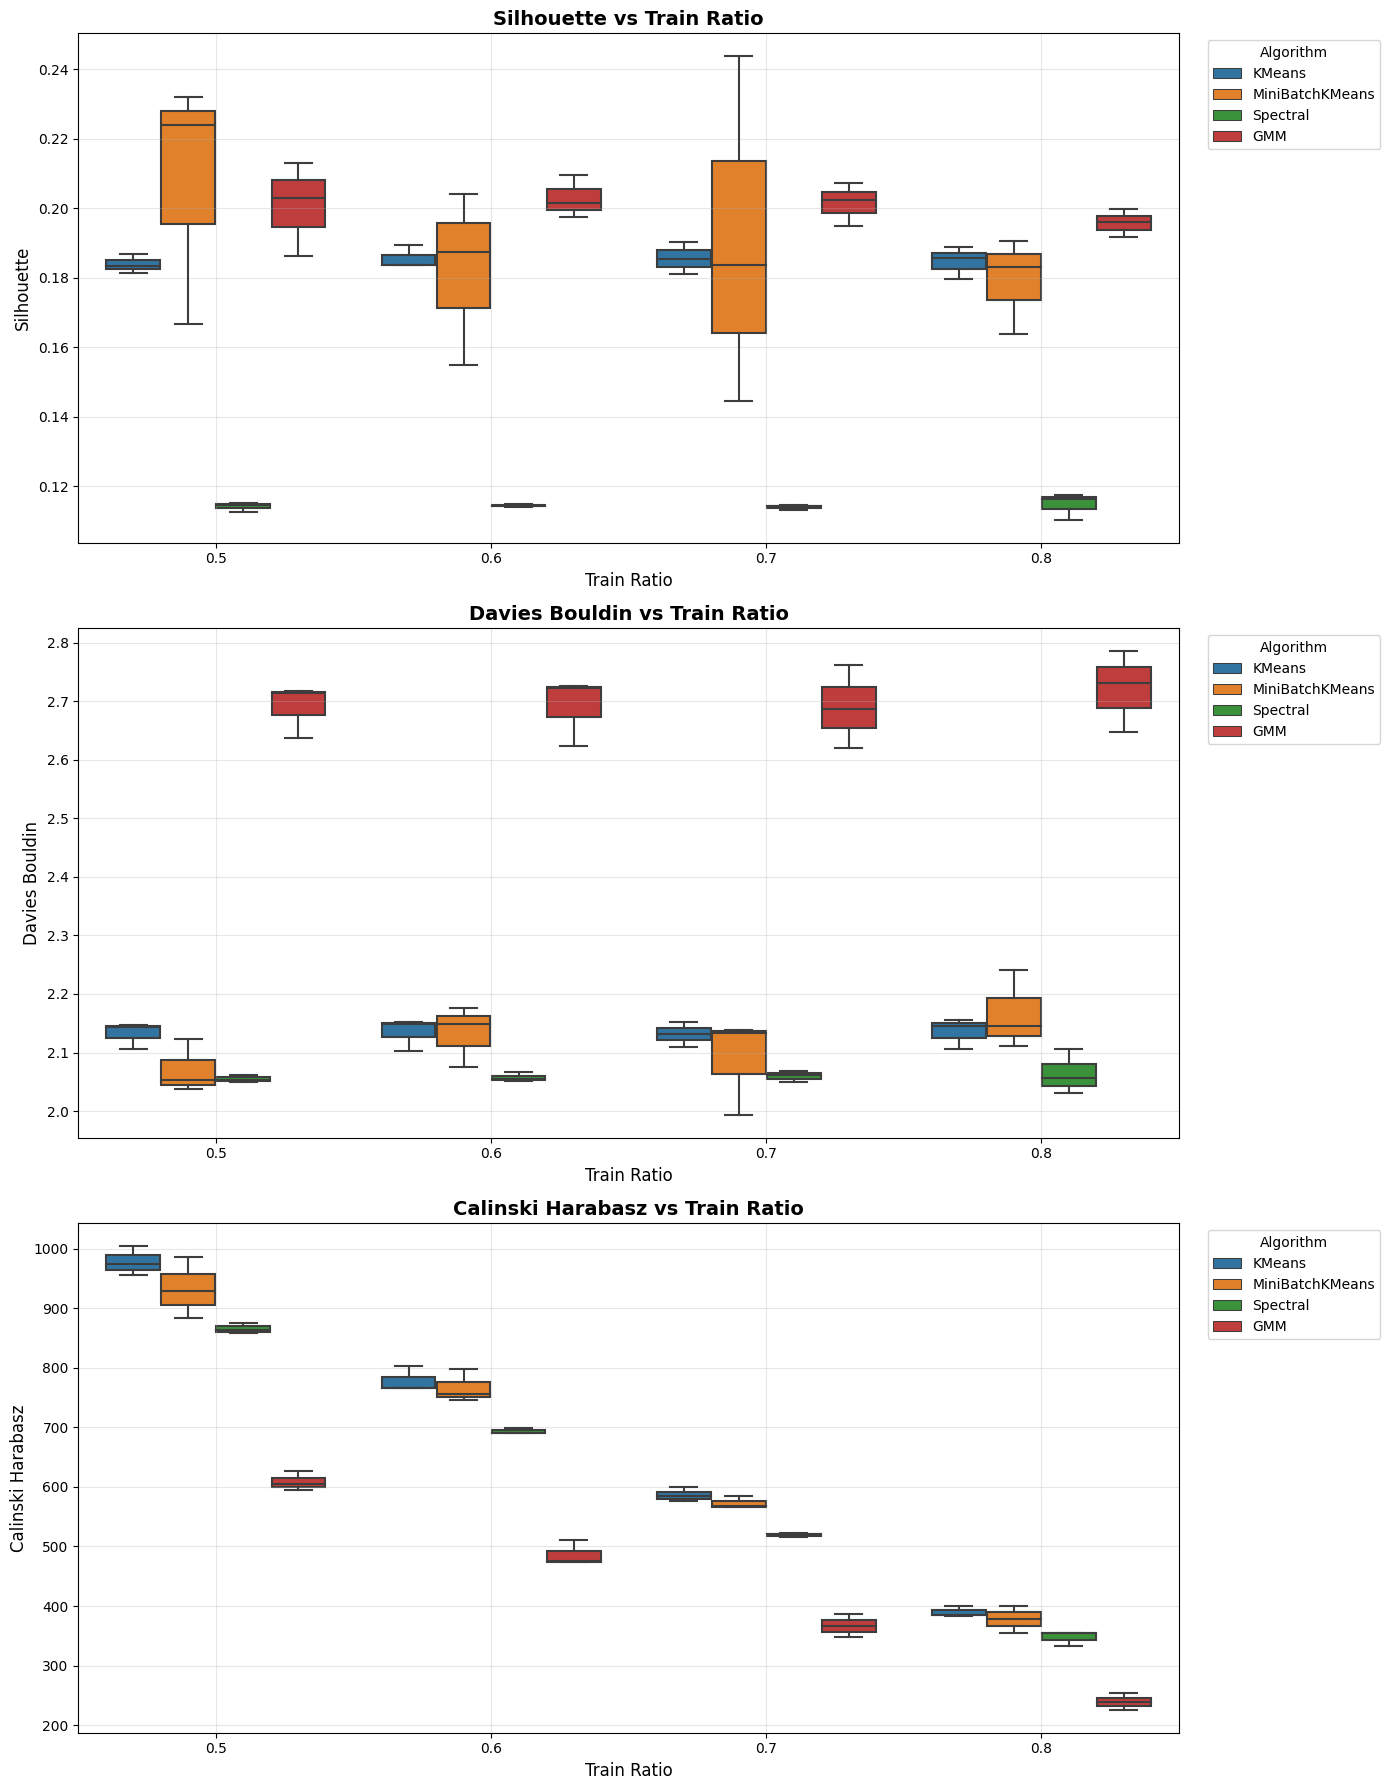

✅ Visualization complete


In [12]:
# Prepare data for visualization
plot_metrics = ["silhouette", "davies_bouldin", "calinski_harabasz"]
plot_metrics = [m for m in plot_metrics if m in res_df.columns]

melted = res_df.melt(
    id_vars=["algo", "train_ratio", "random_state"],
    value_vars=plot_metrics,
    var_name="metric", 
    value_name="score"
)

# Remove NaN values for cleaner plots
melted = melted.dropna(subset=['score'])

# Create comprehensive comparison plot
fig, axes = plt.subplots(len(plot_metrics), 1, figsize=(14, 6*len(plot_metrics)))

if len(plot_metrics) == 1:
    axes = [axes]

for idx, metric in enumerate(plot_metrics):
    data = melted[melted['metric'] == metric]
    
    sns.boxplot(
        data=data, 
        x="train_ratio", 
        y="score", 
        hue="algo",
        ax=axes[idx]
    )
    
    axes[idx].set_title(
        f"{metric.replace('_', ' ').title()} vs Train Ratio",
        fontsize=14, 
        fontweight='bold'
    )
    axes[idx].set_xlabel("Train Ratio", fontsize=12)
    axes[idx].set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    axes[idx].legend(title="Algorithm", bbox_to_anchor=(1.02, 1), loc="upper left")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")

## 🎯 Best Performing Algorithms

Identify the best algorithms for each metric.

In [13]:
# Find best algorithms per metric
print("🏆 Best Performing Algorithms:\n")

# Silhouette (higher is better)
if 'silhouette' in res_df.columns:
    best_sil = res_df.loc[res_df['silhouette'].idxmax()]
    print(f"✓ Best Silhouette Score:")
    print(f"  Algorithm: {best_sil['algo']}")
    print(f"  Score: {best_sil['silhouette']:.4f}")
    print(f"  Train Ratio: {best_sil['train_ratio']:.1%}")
    print(f"  Seed: {best_sil['random_state']}\n")

# Davies-Bouldin (lower is better)
if 'davies_bouldin' in res_df.columns:
    best_db = res_df.loc[res_df['davies_bouldin'].idxmin()]
    print(f"✓ Best Davies-Bouldin Index:")
    print(f"  Algorithm: {best_db['algo']}")
    print(f"  Score: {best_db['davies_bouldin']:.4f}")
    print(f"  Train Ratio: {best_db['train_ratio']:.1%}")
    print(f"  Seed: {best_db['random_state']}\n")

# Calinski-Harabasz (higher is better)
if 'calinski_harabasz' in res_df.columns:
    best_ch = res_df.loc[res_df['calinski_harabasz'].idxmax()]
    print(f"✓ Best Calinski-Harabasz Score:")
    print(f"  Algorithm: {best_ch['algo']}")
    print(f"  Score: {best_ch['calinski_harabasz']:.2f}")
    print(f"  Train Ratio: {best_ch['train_ratio']:.1%}")
    print(f"  Seed: {best_ch['random_state']}\n")

# Average rankings
print("\n📊 Average Performance Rankings:")
avg_performance = res_df.groupby('algo')[plot_metrics].mean().round(4)
display(avg_performance)

🏆 Best Performing Algorithms:

✓ Best Silhouette Score:
  Algorithm: MiniBatchKMeans
  Score: 0.2436
  Train Ratio: 70.0%
  Seed: 0

✓ Best Davies-Bouldin Index:
  Algorithm: MiniBatchKMeans
  Score: 1.9941
  Train Ratio: 70.0%
  Seed: 0

✓ Best Calinski-Harabasz Score:
  Algorithm: KMeans
  Score: 1003.59
  Train Ratio: 50.0%
  Seed: 0


📊 Average Performance Rankings:


,silhouette,davies_bouldin,calinski_harabasz
algo,,,
DBSCAN,NaN,NaN,NaN
GMM,0.2002,2.6976,425.5933
KMeans,0.1849,2.1335,683.1170
MiniBatchKMeans,0.1899,2.1148,662.4772
Spectral,0.1143,2.0590,606.4289


## 📤 Upload Results to W&B

Create a comprehensive results table and upload to W&B.

In [14]:
# Create W&B table with all results
tbl = wandb.Table(dataframe=res_df)

run = wandb.init(
    project=PROJECT, 
    name="msd-aggregate-results", 
    reinit=True,
    config={
        "total_experiments": len(ALL_RUNS),
        "dataset": "MSD",
        "optimal_k": optimal_k,
        "algorithms": list(make_algorithms(optimal_k).keys()),
        "splits": SPLITS,
        "seeds": SEEDS
    }
)

wandb.log({"all_results": tbl})

# Log summary statistics
summary_dict = {}
for algo in res_df['algo'].unique():
    algo_data = res_df[res_df['algo'] == algo]
    for metric in plot_metrics:
        if metric in algo_data.columns:
            summary_dict[f"{algo}_{metric}_mean"] = algo_data[metric].mean()
            summary_dict[f"{algo}_{metric}_std"] = algo_data[metric].std()

wandb.log(summary_dict)

wandb.finish()

print("✅ Results uploaded to W&B successfully!")
print(f"🔗 View your results at: https://wandb.ai/{ENTITY or 'your-username'}/{PROJECT}")

GMM_calinski_harabasz_mean,▁
GMM_calinski_harabasz_std,▁
GMM_davies_bouldin_mean,▁
GMM_davies_bouldin_std,▁
GMM_silhouette_mean,▁
GMM_silhouette_std,▁
KMeans_calinski_harabasz_mean,▁
KMeans_calinski_harabasz_std,▁
KMeans_davies_bouldin_mean,▁
KMeans_davies_bouldin_std,▁
KMeans_silhouette_mean,▁


✅ Results uploaded to W&B successfully!
🔗 View your results at: https://wandb.ai/your-username/msd-clustering


## 💾 Save Results Locally

Export results to CSV for further analysis.

In [16]:
import os

# ✅ Define Kaggle output folder
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ✅ Save results safely
output_path = os.path.join(OUTPUT_DIR, "msd_clustering_results.csv")
res_df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")

# ✅ Save summary safely
summary_path = os.path.join(OUTPUT_DIR, "msd_clustering_summary.csv")
summary.to_csv(summary_path, index=False)
print(f"✅ Summary saved to: {summary_path}")


✅ Results saved to: /kaggle/working/msd_clustering_results.csv
✅ Summary saved to: /kaggle/working/msd_clustering_summary.csv


## 🎓 Conclusions

### Key Findings:

1. **Unsupervised Clustering**: Successfully performed clustering on MSD dataset without genre labels
2. **Algorithm Comparison**: Evaluated 5 different clustering algorithms across multiple metrics
3. **Robustness Testing**: Used multiple train/test splits and random seeds for reliable results
4. **Auto-tuning**: Automatically determined optimal number of clusters and DBSCAN parameters

### Metrics Explained:

- **Silhouette Score** (0 to 1, higher is better): Measures how similar objects are to their own cluster vs other clusters
- **Davies-Bouldin Index** (≥0, lower is better): Average similarity between each cluster and its most similar cluster
- **Calinski-Harabasz Score** (higher is better): Ratio of between-cluster to within-cluster dispersion

### Next Steps:

1. Explore discovered clusters - what makes them different?
2. Try different feature engineering approaches
3. Experiment with dimensionality reduction before clustering
4. Consider ensemble clustering methods

---

**All results are logged to W&B for interactive exploration!** 🚀